In [3]:
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.style.use('fivethirtyeight') # Make the graphs look nice

In [5]:
df = pd.read_csv('demand-forecasting-kernels-only/train.csv')
print(df.head())

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


In [6]:
print("Missing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)
df['date'] = pd.to_datetime(df['date'])
print("\nNew Data Types:\n", df.dtypes)


Missing Values:
 date     0
store    0
item     0
sales    0
dtype: int64

Data Types:
 date     object
store     int64
item      int64
sales     int64
dtype: object

New Data Types:
 date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object


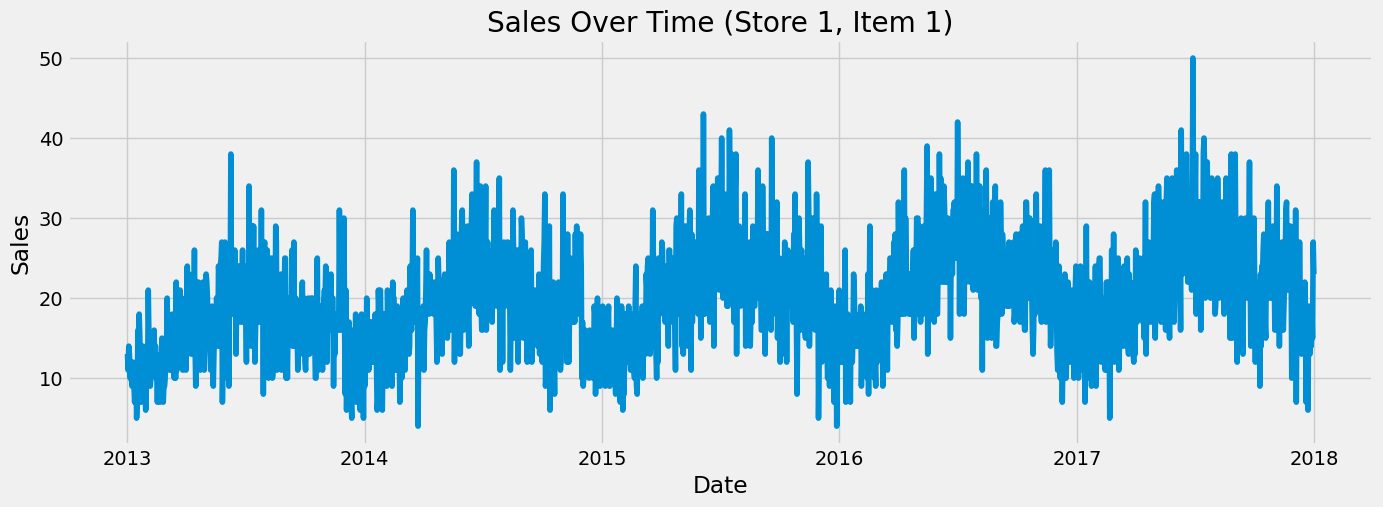

In [7]:
#Exploratory Data Analysis (EDA)
subset = df[(df['store'] == 1) & (df['item'] == 1)]
plt.figure(figsize=(15, 5))
plt.plot(subset['date'], subset['sales'])
plt.title('Sales Over Time (Store 1, Item 1)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

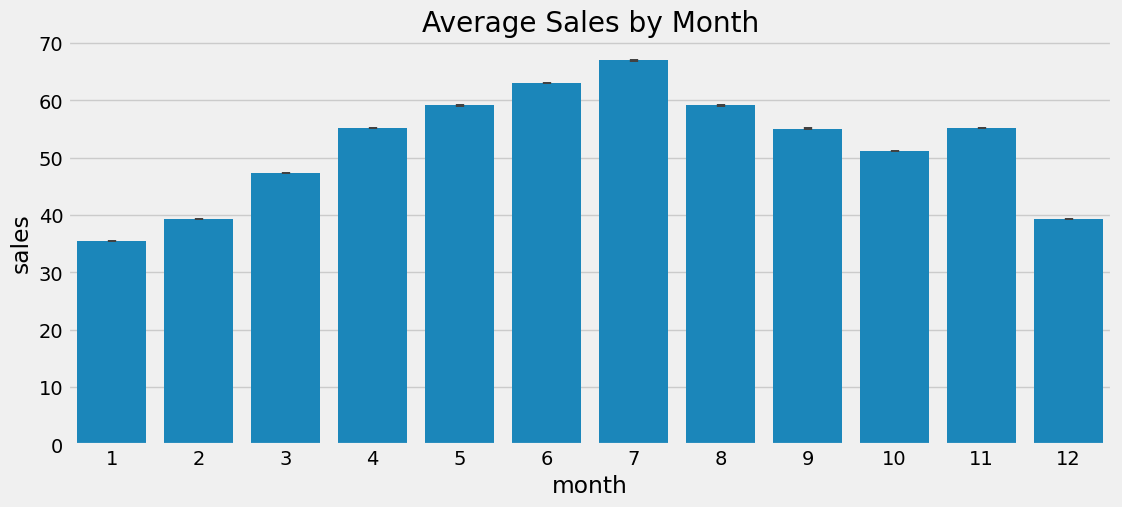

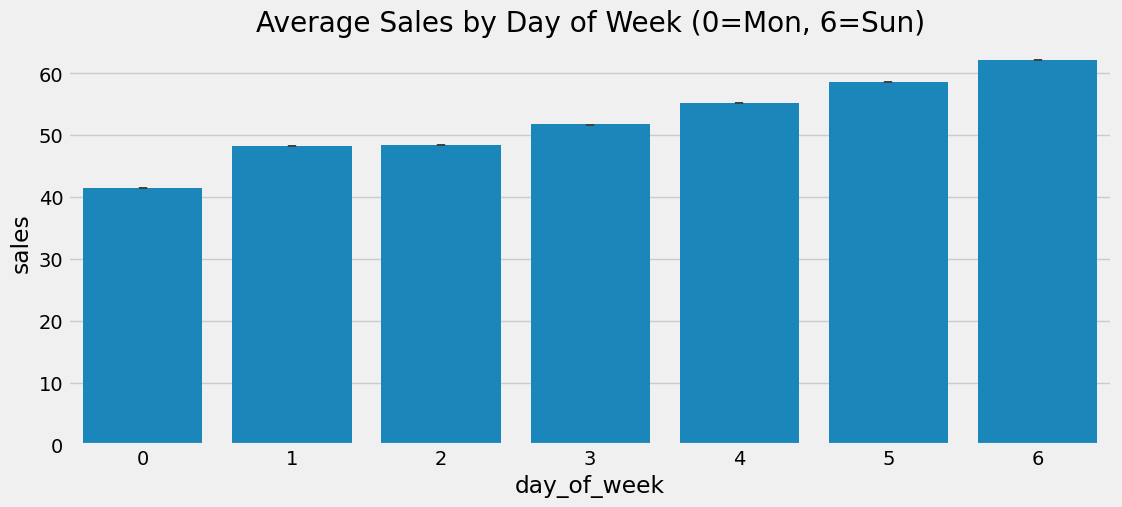

In [8]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek

# Plot 1: Monthly Seasonality
plt.figure(figsize=(12, 5))
sns.barplot(x='month', y='sales', data=df)
plt.title('Average Sales by Month')
plt.show()

# Plot 2: Weekly Seasonality
plt.figure(figsize=(12, 5))
sns.barplot(x='day_of_week', y='sales', data=df)
plt.title('Average Sales by Day of Week (0=Mon, 6=Sun)')
plt.show()

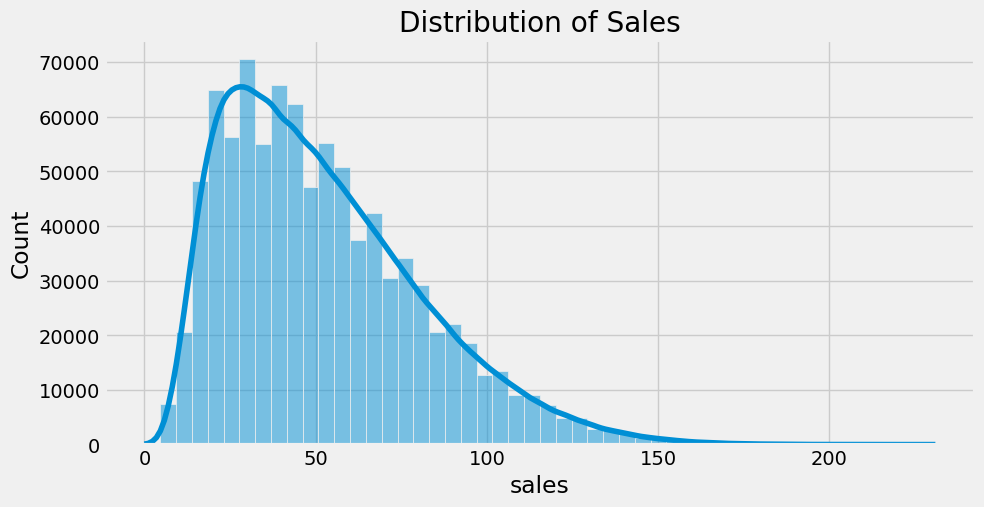

In [9]:
#Distribution Check
plt.figure(figsize=(10, 5))
sns.histplot(df['sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.show()

In [10]:
%pip install holidays

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------------------------ --------------- 0.8/1.3 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.2 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


The Feature Engineering Code

In [14]:
import holidays

df_features = df.copy()

#Time-Based Features
df_features['day_of_week'] = df_features['date'].dt.dayofweek
df_features['month'] = df_features['date'].dt.month
df_features['quarter'] = df_features['date'].dt.quarter
df_features['day_of_year'] = df_features['date'].dt.dayofyear
df_features['is_weekend'] = df_features['day_of_week'] >= 5

#Lag features
df_features['lag_1'] = df_features.groupby(['store', 'item'])['sales'].shift(1) #Sales yesterday
df_features['lag_7'] = df_features.groupby(['store', 'item'])['sales'].shift(7) #Sales same day last week
df_features['lag_365'] = df_features.groupby(['store', 'item'])['sales'].shift(365) #Sales same day last year (Seasonality)

#Rolling Window Statistics (Trends)
df_features['rolling_mean_7'] = df_features.groupby(['store', 'item'])['lag_1'].transform(lambda x: x.rolling(7).mean())

#External Signals (Holidays)
us_holidays = holidays.US()
def is_holiday(date):
    return 1 if date in us_holidays else 0

df_features['is_holiday'] = df_features['date'].apply(is_holiday)

#Cleanup
df_features = df_features.dropna()
print(df_features.head())

          date  store  item  sales  month  year  day_of_week  quarter  \
365 2014-01-01      1     1      9      1  2014            2        1   
366 2014-01-02      1     1     14      1  2014            3        1   
367 2014-01-03      1     1     11      1  2014            4        1   
368 2014-01-04      1     1     20      1  2014            5        1   
369 2014-01-05      1     1     17      1  2014            6        1   

     day_of_year  is_weekend  lag_1  lag_7  lag_365  rolling_mean_7  \
365            1       False   15.0    6.0     13.0       13.000000   
366            2       False    9.0   16.0     11.0       13.428571   
367            3       False   14.0   18.0     14.0       13.142857   
368            4        True   11.0   17.0     13.0       12.142857   
369            5        True   20.0   14.0     10.0       12.571429   

     is_holiday  
365           1  
366           0  
367           0  
368           0  
369           0  
